In [1]:
import itertools
import os
import json

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from experience import load_experience
from bclassification.utils_base import (
    print_class_weights,
    compute_weight_bias,
    print_dataset,
    plot_metrics,
    plot_cm,
    plot_roc,
    describe_results,
)
from bclassification.utils_fcn import create_dataset
from lib.constants import Constants as Const
from lib.data_utils import (
    make_dir,
    env_pf,
    create_results_dir,
    save_dict_to_file,
)
from lib.tf_utils import (
    print_variables,
    ResidulaFCBlock,
    MatthewsCorrelationCoefficient,
)
from lib.visualizer import Visualizer, pprint


experience_dir = make_dir(os.path.join(Const.EXPERIENCE_DIR, "data-aug"))
results_dir = make_dir(os.path.join(Const.RESULTS_DIR, "paper"))

agent_name = "agent-mip"
case_name = "l2rpn_2019_art"
env_dc = True
verbose = False

case_results_dir = make_dir(os.path.join(results_dir, f"{case_name}-{env_pf(env_dc)}"))
case, collector = load_experience(case_name, agent_name, experience_dir, env_dc=env_dc)


L2RPN_2019_ART (dc)


--------------------------------------------------------------------------------
                                        Loading Experience
--------------------------------------------------------------------------------
    - Loading chronics:                 ./experience/data-aug/l2rpn_2019_art-dc/agent-mip-chronic-****
    - Number of loaded chronics:        122


In [33]:
"""
    Parameters
"""

random_seed = 1

input_mode = "structured"
label_mode = "dn"

n_window_targets = 12  # 0 or 12
n_window_history = 0
downsampling_rate = 0.10
n_window_forecasts = 1
use_actions = True
feature_scaling = True
batch_normalization = False

val_frac = 0.10
test_frac = 0.10

# Model
model_type = "res"  # "fc" or "res"
dropout_rate = 0
l1_reg = 1e-7
l2_reg = 0
n_hidden = 512
n_hidden_layers = 4
threshold = 0.50
pos_scaling = 1

# Training
learning_rate = 1e-5
n_batch = 512
n_epochs = 250

In [4]:
"""
    Dataset
"""

_, _, mask_targets, X_all, Y_all = create_dataset(
    case,
    collector,
    input_mode=input_mode,
    label_mode=label_mode,
    n_window_history=n_window_history,
    n_window_targets=n_window_targets,
    downsampling_rate=downsampling_rate,
    n_window_forecasts=n_window_forecasts,
    use_actions=use_actions,
    feature_scaling=feature_scaling,
)

    - Input structure:                  structured
    - Label structure:                  dn
    - Labels:                           7626/740873	1.03 %


In [7]:
"""
    Dataset Split
"""

np.random.seed(random_seed)
tf.random.set_seed(random_seed)

pprint("chronics:", collector.chronic_ids)

chronics_train, chronics_val = train_test_split(
     collector.chronic_ids, test_size=val_frac, random_state=random_seed
)

chronics_train, chronics_test = train_test_split(
     chronics_train, test_size=test_frac / (1 - val_frac), random_state=random_seed
)

chronics_train.sort()
chronics_val.sort()
chronics_test.sort()

train_ids = np.zeros_like(Y_all, dtype=np.bool)
val_ids = np.zeros_like(Y_all, dtype=np.bool)
test_ids = np.zeros_like(Y_all, dtype=np.bool)

start = 0
for chronic_id, chronic_len in zip(collector.chronic_ids, collector.chronic_lengths):
    end = start + chronic_len
    
    if chronic_id in chronics_train:
        train_ids[start:end] = True
    elif chronic_id in chronics_val:
        val_ids[start:end] = True
    elif chronic_id in chronics_test:
        test_ids[start:end] = True
    start = end

# test
pprint("intersection", np.sum(train_ids &  val_ids &  test_ids))
pprint("union", np.sum(train_ids |  val_ids |  test_ids))

mask_train = mask_targets & train_ids
mask_val = mask_targets & val_ids
mask_test = mask_targets & test_ids

X_train, Y_train = X_all[mask_train, :], Y_all[mask_train]
X_val, Y_val = X_all[mask_val, :], Y_all[mask_val]
X_test, Y_test = X_all[mask_test, :], Y_all[mask_test]

chronics:                               [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 120, 121, 122, 123, 124, 125, 126, 127, 128, 151, 152, 153, 154, 155, 156, 157, 158, 159]
    - train                             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26, 27, 29, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 80, 81, 82, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 103, 120, 122, 123, 124, 125, 126, 127, 152, 153, 154, 155, 156, 158, 159]
    - val                  

In [34]:
%%capture cap --no-stderr
class_weight, initial_bias = compute_weight_bias(Y_all[mask_targets])
initial_bias = 0
class_weight[1] = class_weight[1] * pos_scaling 

print_dataset(X_all, Y_all, "All data")
print_dataset(X_all[mask_targets], Y_all[mask_targets], "Data")
print_dataset(X_train, Y_train, "Train")
print_dataset(X_val, Y_val, "Validation")
print_dataset(X_test, Y_test, "Test")

print_class_weights(class_weight)
pprint("Initial bias:", "{:.4f}".format(float(initial_bias)))

model_dir = create_results_dir(case_results_dir, model_name=model_type)

In [35]:
"""
    Model
"""

metrics = [
    tf.keras.metrics.TruePositives(thresholds=threshold, name="tp"),
    tf.keras.metrics.FalsePositives(thresholds=threshold, name="fp"),
    tf.keras.metrics.TrueNegatives(thresholds=threshold, name="tn"),
    tf.keras.metrics.FalseNegatives(thresholds=threshold, name="fn"),
    tf.keras.metrics.BinaryAccuracy(threshold=threshold, name="accuracy"),
    tf.keras.metrics.Precision(thresholds=threshold, name="precision"),
    tf.keras.metrics.Recall(thresholds=threshold, name="recall"),
    MatthewsCorrelationCoefficient(threshold=threshold, name="mcc"),
    tf.keras.metrics.AUC(name="auc"),
]

if l1_reg > 0:
    kwargs_reg = {
        "kernel_regularizer": tf.keras.regularizers.L1(l1_reg),
        "bias_regularizer": tf.keras.regularizers.L1(l1_reg),
    }
elif l2_reg > 0:
    kwargs_reg = {
        "kernel_regularizer": tf.keras.regularizers.L2(l2=l2_reg),
        "bias_regularizer": tf.keras.regularizers.L2(l2=l2_reg),
    }
else:
    kwargs_reg = {}

input_dim = X_train.shape[-1]

tf.random.set_seed(random_seed)
if model_type == "fc":
    hidden_layers = [
        (
            tf.keras.layers.Dense(n_hidden, activation="relu", **kwargs_reg),
            tf.keras.layers.Dropout(dropout_rate),
        )
        for _ in range(n_hidden_layers)
    ]
    hidden_layers = list(itertools.chain(*hidden_layers))

    if batch_normalization:
        hidden_layers = hidden_layers + [tf.keras.layers.BatchNormalization()]
    
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                n_hidden, activation="relu", input_shape=(input_dim,), **kwargs_reg
            ),
            tf.keras.layers.Dropout(dropout_rate),
            *hidden_layers,
            tf.keras.layers.Dense(
                1,
                activation="sigmoid",
                bias_initializer=tf.keras.initializers.Constant(initial_bias),
                **kwargs_reg,
            ),
        ]
    )

elif model_type == "linear":
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                1,
                activation="sigmoid",
                bias_initializer=tf.keras.initializers.Constant(initial_bias), input_shape=(input_dim,),
                **kwargs_reg,
            ),
        ]
    )
else:
    hidden_layers = [
        (
            ResidulaFCBlock(n_hidden, activation="relu", **kwargs_reg),
            tf.keras.layers.Dropout(dropout_rate),
        )
        for _ in range(n_hidden_layers // 2)
    ]
    
    hidden_layers = list(itertools.chain(*hidden_layers))

    if batch_normalization:
        hidden_layers = hidden_layers + [tf.keras.layers.BatchNormalization()]
    
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                n_hidden, activation="relu", input_shape=(input_dim,), **kwargs_reg
            ),
            tf.keras.layers.Dropout(dropout_rate),
            *hidden_layers,
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(
                1,
                activation="sigmoid",
                bias_initializer=tf.keras.initializers.Constant(initial_bias),
                **kwargs_reg,
            ),
        ]
    )

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)

checkpoint_path = os.path.join(model_dir, "ckpts")
ckpt = tf.train.Checkpoint(model=model, optimizer=model.optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

pprint("Model directory:", model_dir)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    pprint("Restoring checkpoint from:", ckpt_manager.latest_checkpoint)
    
param_dict = {
        "random_seed": random_seed,
        "input_mode": input_mode,
        "label_mode": label_mode,
        "val_frac": val_frac,
        "downsampling_rate": downsampling_rate,
        "n_window_targets": n_window_targets,
        "n_window_history": n_window_history,
        "use_actions": use_actions,
        "feature_scaling": feature_scaling,
        "model_type": model_type,
        "dropout_rate": dropout_rate,
        "l1_reg": l1_reg,
        "l2_reg": l2_reg,
        "n_hidden": n_hidden,
        "n_hidden_layers": n_hidden_layers,
        "learning_rate": learning_rate,
        "n_batch": n_batch,
        "n_epochs": n_epochs,
        "threshold": threshold,
        "pos_scaling": pos_scaling,
        "batch_normalization": batch_normalization,
}
print(json.dumps(param_dict, indent=2, sort_keys=True))
save_dict_to_file(
    param_dict,
    os.path.join(model_dir, "params.txt"),
)

Model directory:                        ./results\paper\l2rpn_2019_art-dc\2021-02-05_01-17-36_res
{
  "batch_normalization": false,
  "downsampling_rate": 0.1,
  "dropout_rate": 0,
  "feature_scaling": true,
  "input_mode": "structured",
  "l1_reg": 1e-07,
  "l2_reg": 0,
  "label_mode": "dn",
  "learning_rate": 1e-05,
  "model_type": "res",
  "n_batch": 512,
  "n_epochs": 250,
  "n_hidden": 512,
  "n_hidden_layers": 4,
  "n_window_history": 0,
  "n_window_targets": 12,
  "pos_scaling": 1,
  "random_seed": 1,
  "threshold": 0.5,
  "use_actions": true,
  "val_frac": 0.1
}


In [36]:
"""
    Training
"""
# tensorboard_path = os.path.join(model_dir, "logs")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(
#     log_dir=tensorboard_path, write_graph=False, write_images=False, update_freq="epoch"
# )

# print(f"tensorboard --logdir={tensorboard_path}")

training = model.fit(
    X_train,
    Y_train,
    epochs=n_epochs,
    batch_size=n_batch,
    class_weight=class_weight,
    validation_data=(X_val, Y_val),
    # callbacks=[tensorboard_callback],
    verbose=1,
)

ckpt_save_path = ckpt_manager.save()
pprint(f"    - Saving checkpoint to:", ckpt_save_path)

Epoch 1/250
111/111 [==============================] - 13s 78ms/step - loss: 0.6821 - tp: 1739.1875 - fp: 9883.1875 - tn: 16056.8393 - fn: 1244.1250 - accuracy: 0.5297 - precision: 0.1399 - recall: 0.6383 - mcc: nan - auc: 0.6191 - val_loss: 0.7258 - val_tp: 633.0000 - val_fp: 3121.0000 - val_tn: 3255.0000 - val_fn: 187.0000 - val_accuracy: 0.5403 - val_precision: 0.1686 - val_recall: 0.7720 - val_mcc: 0.1797 - val_auc: 0.7016
Epoch 2/250
111/111 [==============================] - 7s 63ms/step - loss: 0.6244 - tp: 1923.2857 - fp: 7300.6696 - tn: 18617.2321 - fn: 1082.1518 - accuracy: 0.7039 - precision: 0.2083 - recall: 0.6476 - mcc: 0.2342 - auc: 0.7488 - val_loss: 0.7303 - val_tp: 632.0000 - val_fp: 2860.0000 - val_tn: 3516.0000 - val_fn: 188.0000 - val_accuracy: 0.5764 - val_precision: 0.1810 - val_recall: 0.7707 - val_mcc: 0.2048 - val_auc: 0.7220
Epoch 3/250
111/111 [==============================] - 7s 65ms/step - loss: 0.6030 - tp: 2030.6607 - fp: 7623.1607 - tn: 18285.9464 - fn

Epoch 20/250
111/111 [==============================] - 8s 76ms/step - loss: 0.4934 - tp: 2446.9732 - fp: 7109.7232 - tn: 18773.0179 - fn: 593.6250 - accuracy: 0.7335 - precision: 0.2551 - recall: 0.8010 - mcc: 0.3434 - auc: 0.8420 - val_loss: 0.6245 - val_tp: 632.0000 - val_fp: 2241.0000 - val_tn: 4135.0000 - val_fn: 188.0000 - val_accuracy: 0.6625 - val_precision: 0.2200 - val_recall: 0.7707 - val_mcc: 0.2720 - val_auc: 0.7815
Epoch 21/250
111/111 [==============================] - 8s 75ms/step - loss: 0.4883 - tp: 2500.7054 - fp: 6961.6339 - tn: 18909.7411 - fn: 551.2589 - accuracy: 0.7408 - precision: 0.2671 - recall: 0.8227 - mcc: 0.3638 - auc: 0.8486 - val_loss: 0.6167 - val_tp: 628.0000 - val_fp: 2200.0000 - val_tn: 4176.0000 - val_fn: 192.0000 - val_accuracy: 0.6676 - val_precision: 0.2221 - val_recall: 0.7659 - val_mcc: 0.2738 - val_auc: 0.7848
Epoch 22/250
111/111 [==============================] - 8s 75ms/step - loss: 0.4783 - tp: 2451.2411 - fp: 6812.0446 - tn: 19102.9107 -

Epoch 39/250
111/111 [==============================] - 9s 81ms/step - loss: 0.4125 - tp: 2552.3571 - fp: 5899.3571 - tn: 20021.4375 - fn: 450.1875 - accuracy: 0.7820 - precision: 0.3006 - recall: 0.8483 - mcc: 0.4166 - auc: 0.8928 - val_loss: 0.5974 - val_tp: 682.0000 - val_fp: 2102.0000 - val_tn: 4274.0000 - val_fn: 138.0000 - val_accuracy: 0.6887 - val_precision: 0.2450 - val_recall: 0.8317 - val_mcc: 0.3275 - val_auc: 0.8261
Epoch 40/250
111/111 [==============================] - 9s 85ms/step - loss: 0.4194 - tp: 2558.6250 - fp: 5896.2054 - tn: 20018.3125 - fn: 450.1964 - accuracy: 0.7811 - precision: 0.3018 - recall: 0.8499 - mcc: 0.4176 - auc: 0.8907 - val_loss: 0.5397 - val_tp: 647.0000 - val_fp: 1872.0000 - val_tn: 4504.0000 - val_fn: 173.0000 - val_accuracy: 0.7158 - val_precision: 0.2568 - val_recall: 0.7890 - val_mcc: 0.3300 - val_auc: 0.8264
Epoch 41/250
111/111 [==============================] - 11s 98ms/step - loss: 0.4226 - tp: 2603.7500 - fp: 5939.5357 - tn: 19927.0982 

Epoch 58/250
111/111 [==============================] - 9s 80ms/step - loss: 0.3736 - tp: 2676.9821 - fp: 5081.6875 - tn: 20782.3839 - fn: 382.2857 - accuracy: 0.8098 - precision: 0.3454 - recall: 0.8801 - mcc: 0.4728 - auc: 0.9167 - val_loss: 0.5052 - val_tp: 650.0000 - val_fp: 1669.0000 - val_tn: 4707.0000 - val_fn: 170.0000 - val_accuracy: 0.7444 - val_precision: 0.2803 - val_recall: 0.7927 - val_mcc: 0.3610 - val_auc: 0.8460
Epoch 59/250
111/111 [==============================] - 11s 96ms/step - loss: 0.3676 - tp: 2633.1518 - fp: 4996.7857 - tn: 20896.5982 - fn: 396.8036 - accuracy: 0.8166 - precision: 0.3474 - recall: 0.8666 - mcc: 0.4718 - auc: 0.9175 - val_loss: 0.5484 - val_tp: 668.0000 - val_fp: 1841.0000 - val_tn: 4535.0000 - val_fn: 152.0000 - val_accuracy: 0.7230 - val_precision: 0.2662 - val_recall: 0.8146 - val_mcc: 0.3507 - val_auc: 0.8474- fn: 343.5979 - accuracy: 0.8172 - precision: 0.3481 - recall: 0.8664 - mcc: 0.472
Epoch 60/250
111/111 [============================

Epoch 77/250
111/111 [==============================] - 11s 95ms/step - loss: 0.3407 - tp: 2686.0804 - fp: 4349.1607 - tn: 21531.3125 - fn: 356.7857 - accuracy: 0.8363 - precision: 0.3823 - recall: 0.8812 - mcc: 0.5103 - auc: 0.9309 - val_loss: 0.6217 - val_tp: 696.0000 - val_fp: 1970.0000 - val_tn: 4406.0000 - val_fn: 124.0000 - val_accuracy: 0.7090 - val_precision: 0.2611 - val_recall: 0.8488 - val_mcc: 0.3552 - val_auc: 0.8542
Epoch 78/250
111/111 [==============================] - 10s 89ms/step - loss: 0.3425 - tp: 2640.0536 - fp: 4497.4821 - tn: 21415.8393 - fn: 369.9643 - accuracy: 0.8287 - precision: 0.3661 - recall: 0.8798 - mcc: 0.4954 - auc: 0.9283 - val_loss: 0.5170 - val_tp: 666.0000 - val_fp: 1621.0000 - val_tn: 4755.0000 - val_fn: 154.0000 - val_accuracy: 0.7533 - val_precision: 0.2912 - val_recall: 0.8122 - val_mcc: 0.3808 - val_auc: 0.8585
Epoch 79/250
111/111 [==============================] - 9s 81ms/step - loss: 0.3300 - tp: 2670.2857 - fp: 4224.7321 - tn: 21684.3036

Epoch 96/250
111/111 [==============================] - 9s 79ms/step - loss: 0.3130 - tp: 2714.0357 - fp: 3997.8571 - tn: 21892.4732 - fn: 318.9732 - accuracy: 0.8476 - precision: 0.4011 - recall: 0.8985 - mcc: 0.5353 - auc: 0.9415 - val_loss: 0.5295 - val_tp: 664.0000 - val_fp: 1557.0000 - val_tn: 4819.0000 - val_fn: 156.0000 - val_accuracy: 0.7620 - val_precision: 0.2990 - val_recall: 0.8098 - val_mcc: 0.3890 - val_auc: 0.8604
Epoch 97/250
111/111 [==============================] - 9s 79ms/step - loss: 0.3120 - tp: 2687.2143 - fp: 3825.6518 - tn: 22096.0714 - fn: 314.4018 - accuracy: 0.8574 - precision: 0.4144 - recall: 0.8963 - mcc: 0.5477 - auc: 0.9413 - val_loss: 0.5176 - val_tp: 656.0000 - val_fp: 1508.0000 - val_tn: 4868.0000 - val_fn: 164.0000 - val_accuracy: 0.7676 - val_precision: 0.3031 - val_recall: 0.8000 - val_mcc: 0.3905 - val_auc: 0.8595
Epoch 98/250
111/111 [==============================] - 9s 79ms/step - loss: 0.3122 - tp: 2745.1786 - fp: 3819.8214 - tn: 22039.0536 -

Epoch 115/250
111/111 [==============================] - 9s 83ms/step - loss: 0.2828 - tp: 2714.7411 - fp: 3442.1875 - tn: 22478.0179 - fn: 288.3929 - accuracy: 0.8722 - precision: 0.4428 - recall: 0.9037 - mcc: 0.5763 - auc: 0.9520 - val_loss: 0.5165 - val_tp: 645.0000 - val_fp: 1433.0000 - val_tn: 4943.0000 - val_fn: 175.0000 - val_accuracy: 0.7765 - val_precision: 0.3104 - val_recall: 0.7866 - val_mcc: 0.3939 - val_auc: 0.8621
Epoch 116/250
111/111 [==============================] - 10s 88ms/step - loss: 0.2838 - tp: 2739.4107 - fp: 3511.4554 - tn: 22385.0714 - fn: 287.4018 - accuracy: 0.8683 - precision: 0.4400 - recall: 0.9104 - mcc: 0.5754 - auc: 0.9522 - val_loss: 0.5481 - val_tp: 665.0000 - val_fp: 1521.0000 - val_tn: 4855.0000 - val_fn: 155.0000 - val_accuracy: 0.7671 - val_precision: 0.3042 - val_recall: 0.8110 - val_mcc: 0.3955 - val_auc: 0.8623
Epoch 117/250
111/111 [==============================] - 9s 81ms/step - loss: 0.2834 - tp: 2720.6339 - fp: 3428.3393 - tn: 22493.58

111/111 [==============================] - 10s 93ms/step - loss: 0.2638 - tp: 2754.6429 - fp: 3174.4821 - tn: 22741.1339 - fn: 253.0804 - accuracy: 0.8803 - precision: 0.4610 - recall: 0.9177 - mcc: 0.5977 - auc: 0.9583 - val_loss: 0.5435 - val_tp: 654.0000 - val_fp: 1428.0000 - val_tn: 4948.0000 - val_fn: 166.0000 - val_accuracy: 0.7785 - val_precision: 0.3141 - val_recall: 0.7976 - val_mcc: 0.4019 - val_auc: 0.8635
Epoch 134/250
111/111 [==============================] - 9s 84ms/step - loss: 0.2614 - tp: 2713.8393 - fp: 3146.5536 - tn: 22802.8750 - fn: 260.0714 - accuracy: 0.8824 - precision: 0.4607 - recall: 0.9127 - mcc: 0.5965 - auc: 0.9582 - val_loss: 0.4550 - val_tp: 599.0000 - val_fp: 1145.0000 - val_tn: 5231.0000 - val_fn: 221.0000 - val_accuracy: 0.8102 - val_precision: 0.3435 - val_recall: 0.7305 - val_mcc: 0.4085 - val_auc: 0.8609
Epoch 135/250
111/111 [==============================] - 9s 85ms/step - loss: 0.2565 - tp: 2799.3482 - fp: 3130.9196 - tn: 22750.3571 - fn: 242.7

111/111 [==============================] - 10s 94ms/step - loss: 0.2480 - tp: 2758.2946 - fp: 2982.6429 - tn: 22947.5893 - fn: 234.8125 - accuracy: 0.8872 - precision: 0.4775 - recall: 0.9237 - mcc: 0.6142 - auc: 0.9629 - val_loss: 0.4488 - val_tp: 602.0000 - val_fp: 1073.0000 - val_tn: 5303.0000 - val_fn: 218.0000 - val_accuracy: 0.8206 - val_precision: 0.3594 - val_recall: 0.7341 - val_mcc: 0.4255 - val_auc: 0.8634
Epoch 152/250
111/111 [==============================] - 9s 79ms/step - loss: 0.2422 - tp: 2761.2946 - fp: 2885.1607 - tn: 23034.1429 - fn: 242.7411 - accuracy: 0.8936 - precision: 0.4936 - recall: 0.9155 - mcc: 0.6240 - auc: 0.9646 - val_loss: 0.5910 - val_tp: 654.0000 - val_fp: 1495.0000 - val_tn: 4881.0000 - val_fn: 166.0000 - val_accuracy: 0.7692 - val_precision: 0.3043 - val_recall: 0.7976 - val_mcc: 0.3910 - val_auc: 0.8622
Epoch 153/250
111/111 [==============================] - 9s 83ms/step - loss: 0.2435 - tp: 2796.1964 - fp: 2841.8929 - tn: 23056.6607 - fn: 228.5

Epoch 170/250
111/111 [==============================] - 8s 76ms/step - loss: 0.2310 - tp: 2837.8304 - fp: 2735.6964 - tn: 23143.0357 - fn: 206.7768 - accuracy: 0.8982 - precision: 0.5111 - recall: 0.9348 - mcc: 0.6453 - auc: 0.9681 - val_loss: 0.5071 - val_tp: 615.0000 - val_fp: 1209.0000 - val_tn: 5167.0000 - val_fn: 205.0000 - val_accuracy: 0.8035 - val_precision: 0.3372 - val_recall: 0.7500 - val_mcc: 0.4093 - val_auc: 0.8608
Epoch 171/250
111/111 [==============================] - 8s 75ms/step - loss: 0.2324 - tp: 2819.2500 - fp: 2635.1875 - tn: 23253.9464 - fn: 214.9554 - accuracy: 0.9021 - precision: 0.5197 - recall: 0.9284 - mcc: 0.6499 - auc: 0.9679 - val_loss: 0.5185 - val_tp: 621.0000 - val_fp: 1207.0000 - val_tn: 5169.0000 - val_fn: 199.0000 - val_accuracy: 0.8046 - val_precision: 0.3397 - val_recall: 0.7573 - val_mcc: 0.4146 - val_auc: 0.8625
Epoch 172/250
111/111 [==============================] - 9s 80ms/step - loss: 0.2272 - tp: 2805.3482 - fp: 2676.0268 - tn: 23216.803

111/111 [==============================] - 9s 78ms/step - loss: 0.2151 - tp: 2874.1696 - fp: 2477.6161 - tn: 23388.2500 - fn: 183.3036 - accuracy: 0.9062 - precision: 0.5360 - recall: 0.9394 - mcc: 0.6666 - auc: 0.9728 - val_loss: 0.5084 - val_tp: 600.0000 - val_fp: 1137.0000 - val_tn: 5239.0000 - val_fn: 220.0000 - val_accuracy: 0.8114 - val_precision: 0.3454 - val_recall: 0.7317 - val_mcc: 0.4109 - val_auc: 0.8590
Epoch 189/250
111/111 [==============================] - 8s 76ms/step - loss: 0.2101 - tp: 2818.4196 - fp: 2425.5179 - tn: 23495.3571 - fn: 184.0446 - accuracy: 0.9100 - precision: 0.5376 - recall: 0.9384 - mcc: 0.6692 - auc: 0.9733 - val_loss: 0.4874 - val_tp: 602.0000 - val_fp: 1067.0000 - val_tn: 5309.0000 - val_fn: 218.0000 - val_accuracy: 0.8214 - val_precision: 0.3607 - val_recall: 0.7341 - val_mcc: 0.4267 - val_auc: 0.8620
Epoch 190/250
111/111 [==============================] - 8s 76ms/step - loss: 0.2099 - tp: 2851.5625 - fp: 2435.7857 - tn: 23463.3750 - fn: 172.61

Epoch 207/250
111/111 [==============================] - 9s 83ms/step - loss: 0.2019 - tp: 2843.3661 - fp: 2353.2232 - tn: 23561.4107 - fn: 165.3393 - accuracy: 0.9121 - precision: 0.5441 - recall: 0.9474 - mcc: 0.6780 - auc: 0.9751 - val_loss: 0.5511 - val_tp: 615.0000 - val_fp: 1194.0000 - val_tn: 5182.0000 - val_fn: 205.0000 - val_accuracy: 0.8056 - val_precision: 0.3400 - val_recall: 0.7500 - val_mcc: 0.4122 - val_auc: 0.8595
Epoch 208/250
111/111 [==============================] - 9s 77ms/step - loss: 0.1939 - tp: 2844.1161 - fp: 2268.1875 - tn: 23650.0089 - fn: 161.0268 - accuracy: 0.9160 - precision: 0.5572 - recall: 0.9495 - mcc: 0.6889 - auc: 0.9771 - val_loss: 0.6087 - val_tp: 630.0000 - val_fp: 1340.0000 - val_tn: 5036.0000 - val_fn: 190.0000 - val_accuracy: 0.7874 - val_precision: 0.3198 - val_recall: 0.7683 - val_mcc: 0.3977 - val_auc: 0.8576
Epoch 209/250
111/111 [==============================] - 8s 76ms/step - loss: 0.1902 - tp: 2831.0000 - fp: 2235.3482 - tn: 23711.151

Epoch 226/250
111/111 [==============================] - 8s 76ms/step - loss: 0.1840 - tp: 2872.0982 - fp: 2110.2679 - tn: 23799.8393 - fn: 141.1339 - accuracy: 0.9223 - precision: 0.5764 - recall: 0.9550 - mcc: 0.7060 - auc: 0.9793 - val_loss: 0.5878 - val_tp: 611.0000 - val_fp: 1220.0000 - val_tn: 5156.0000 - val_fn: 209.0000 - val_accuracy: 0.8014 - val_precision: 0.3337 - val_recall: 0.7451 - val_mcc: 0.4040 - val_auc: 0.8556
Epoch 227/250
111/111 [==============================] - 8s 76ms/step - loss: 0.1820 - tp: 2867.9821 - fp: 2065.2500 - tn: 23856.1518 - fn: 133.9554 - accuracy: 0.9244 - precision: 0.5823 - recall: 0.9540 - mcc: 0.7103 - auc: 0.9797 - val_loss: 0.6418 - val_tp: 637.0000 - val_fp: 1373.0000 - val_tn: 5003.0000 - val_fn: 183.0000 - val_accuracy: 0.7838 - val_precision: 0.3169 - val_recall: 0.7768 - val_mcc: 0.3977 - val_auc: 0.8572
Epoch 228/250
111/111 [==============================] - 8s 75ms/step - loss: 0.1834 - tp: 2894.6607 - fp: 2115.4286 - tn: 23781.928

111/111 [==============================] - 10s 87ms/step - loss: 0.1678 - tp: 2849.6786 - fp: 1932.0536 - tn: 24008.4911 - fn: 133.1161 - accuracy: 0.9291 - precision: 0.5981 - recall: 0.9538 - mcc: 0.7221 - auc: 0.9825 - val_loss: 0.6372 - val_tp: 624.0000 - val_fp: 1296.0000 - val_tn: 5080.0000 - val_fn: 196.0000 - val_accuracy: 0.7927 - val_precision: 0.3250 - val_recall: 0.7610 - val_mcc: 0.4007 - val_auc: 0.8564
Epoch 245/250
111/111 [==============================] - 9s 82ms/step - loss: 0.1726 - tp: 2881.3214 - fp: 1979.4821 - tn: 23938.1964 - fn: 124.3393 - accuracy: 0.9274 - precision: 0.5909 - recall: 0.9583 - mcc: 0.7188 - auc: 0.9814 - val_loss: 0.6240 - val_tp: 615.0000 - val_fp: 1272.0000 - val_tn: 5104.0000 - val_fn: 205.0000 - val_accuracy: 0.7947 - val_precision: 0.3259 - val_recall: 0.7500 - val_mcc: 0.3977 - val_auc: 0.8512
Epoch 246/250
111/111 [==============================] - 8s 75ms/step - loss: 0.1685 - tp: 2925.8571 - fp: 1952.5179 - tn: 23934.6607 - fn: 110.3

In [38]:
%%capture cap --no-stderr
"""
    Results
"""
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix
from lib.rewards import correct_predictions

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    pprint("Restoring checkpoint from:", ckpt_manager.latest_checkpoint)

print_variables(model.trainable_variables)
plot_metrics(training, Y_train, Y_val, save_dir=model_dir)

results_train = model.evaluate(X_train, Y_train, batch_size=n_batch, verbose=0)
results_val = model.evaluate(X_val, Y_val, batch_size=n_batch, verbose=0)
results_test = model.evaluate(X_test, Y_test, batch_size=n_batch, verbose=0)

Y_train_pred = model.predict(X_train, batch_size=n_batch)
Y_val_pred = model.predict(X_val, batch_size=n_batch)
Y_test_pred = model.predict(X_test, batch_size=n_batch)

describe_results(model.metrics_names, results_train, Y_train, name="Train")
pprint("    - F1:", "{:.4f}".format(f1_score(Y_train, np.greater(Y_train_pred, threshold)), average="binary"))
describe_results(model.metrics_names, results_val, Y_val, name="Validation")
pprint("    - F1:", "{:.4f}".format(f1_score(Y_val, np.greater(Y_val_pred, threshold)), average="binary"))
describe_results(model.metrics_names, results_test, Y_test, name="Test")
pprint("    - F1:", "{:.4f}".format(f1_score(Y_test, np.greater(Y_test_pred, threshold)), average="binary"))

plot_roc(
    [
        ("Training", Y_train, Y_train_pred),
        ("Validation", Y_val, Y_val_pred),
        ("Test", Y_test, Y_test_pred),
    ],
    save_dir=model_dir,
)

Y_all_train_pred = np.greater(model.predict(X_all[train_ids, :], batch_size=n_batch), threshold) 
Y_all_val_pred = np.greater(model.predict(X_all[val_ids, :], batch_size=n_batch), threshold)
Y_all_test_pred = np.greater(model.predict(X_all[test_ids, :], batch_size=n_batch), threshold)

In [68]:
import pandas as pd


def describe_falses(y, y_pred, dataset_name):
    cm = confusion_matrix(y, y_pred)
    fp = cm[0, 1]
    fn = cm[1, 0]
    
    n = np.sum(np.equal(y, 0))
    p = np.sum(np.equal(y, 1))
    fpr = fp / n
    fnr = fn / p
    
    mcc = matthews_corrcoef(y, y_pred)
    
#     pprint("    - Dataset", dataset_name)
#     pprint("        - FPR (C):","{:<15}{:>8.2f}".format("{}/{}".format(int(fp), int(n)), fpr))
#     pprint("        - FNR (C):","{:<15}{:>8.2f}".format("{}/{}".format(int(fn), int(p)), fnr))
#     pprint("        - MCC (C):", "{:.4f}".format(mcc))
    
    return mcc, fpr, fnr


row = ["w_f \\ w_b"] + [str(w_b) for w_b in np.arange(0, 37, 12)]
mccs_train = [row]
mccs_val = [row]
mccs_test = [row]

for w_f in np.arange(0, 37, 12):
    row_train = [str(w_f)]
    row_val = [str(w_f)]
    row_test = [str(w_f)]
    
    for w_b in np.arange(0, 37, 12):
#         Y_train_pred_c = correct_predictions(Y_all[train_ids], Y_all_train_pred, w_f=w_f, w_b=w_b)[mask_targets[train_ids]]
#         res = describe_falses(Y_train, Y_train_pred_c, "Train")
#         row_train.append("{:.3f}/{:.3f}/{:.3f}".format(*res))
        
        Y_val_pred_c = correct_predictions(Y_all[val_ids], Y_all_val_pred, w_f=w_f, w_b=w_b)[mask_targets[val_ids]]
        res = describe_falses(Y_val, Y_val_pred_c, "Val")
        row_val.append("{:.3f}/{:.3f}/{:.3f}".format(*res))
        
        Y_test_pred_c = correct_predictions(Y_all[test_ids], Y_all_test_pred, w_f=w_f, w_b=w_b)[mask_targets[test_ids]]
        res = describe_falses(Y_test, Y_test_pred_c, "Test")
        row_test.append("{:.3f}/{:.3f}/{:.3f}".format(*res))

    mccs_train.append(row_train)
    mccs_val.append(row_val)
    mccs_test.append(row_test)

In [67]:
print("train")
print(pd.DataFrame(mccs_train).to_string(index=False))

print("\nval")
print(pd.DataFrame(mccs_val).to_string(index=False))

print("\ntest")
print(pd.DataFrame(mccs_test).to_string(index=False))

train
        0                 1                 2                 3                 4
w_f \ w_b                 0                12                24                36
        0 0.733/0.075/0.029 0.739/0.075/0.019 0.742/0.075/0.015 0.744/0.075/0.011
       12 0.733/0.075/0.029 0.739/0.075/0.019 0.742/0.075/0.015 0.744/0.075/0.011
       24 0.801/0.049/0.029 0.808/0.049/0.019 0.810/0.049/0.015 0.812/0.049/0.011
       36 0.840/0.036/0.029 0.846/0.036/0.019 0.849/0.036/0.015 0.851/0.036/0.011

val
        0                 1                 2                 3                 4
w_f \ w_b                 0                12                24                36
        0 0.409/0.179/0.270 0.462/0.179/0.190 0.486/0.179/0.154 0.503/0.179/0.128
       12 0.409/0.179/0.270 0.462/0.179/0.190 0.486/0.179/0.154 0.503/0.179/0.128
       24 0.464/0.139/0.270 0.518/0.139/0.190 0.543/0.139/0.154 0.560/0.139/0.128
       36 0.506/0.113/0.270 0.561/0.113/0.190 0.586/0.113/0.154 0.603/0.113/0.128

test

Restoring checkpoint from:              ./results\paper\l2rpn_2019_art-dc\2021-02-05_01-17-36_res\ckpts\ckpt-1
Name                                         Shape	   Param #	   L2-Norm
dense_10/kernel:0                       (214, 512)	    109568	     11.71
dense_10/bias:0                             (512,)	       512	      0.05
residula_fc_block_2/dense_6/kernel:0    (512, 512)	    262144	     19.25
residula_fc_block_2/dense_6/bias:0          (512,)	       512	      0.03
residula_fc_block_2/dense_7/kernel:0    (512, 512)	    262144	     20.99
residula_fc_block_2/dense_7/bias:0          (512,)	       512	      0.03
residula_fc_block_3/dense_8/kernel:0    (512, 512)	    262144	     20.63
residula_fc_block_3/dense_8/bias:0          (512,)	       512	      0.03
residula_fc_block_3/dense_9/kernel:0    (512, 512)	    262144	     21.78
residula_fc_block_3/dense_9/bias:0          (512,)	       512	      0.04
dense_11/kernel:0                         (512, 1)	       512	      1.99
dense_11/bias

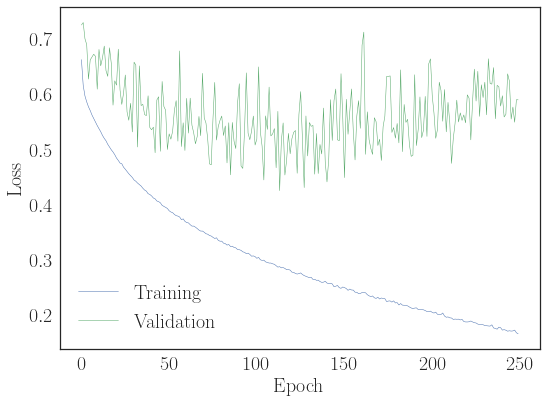

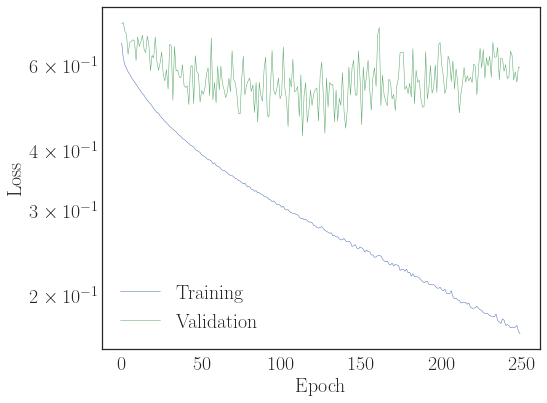

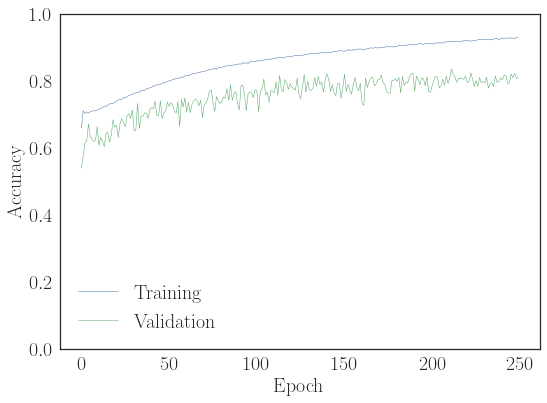

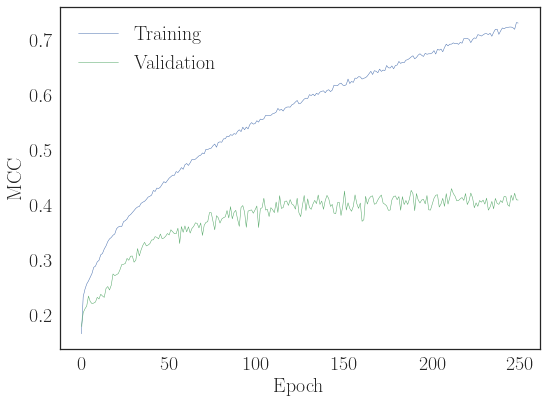

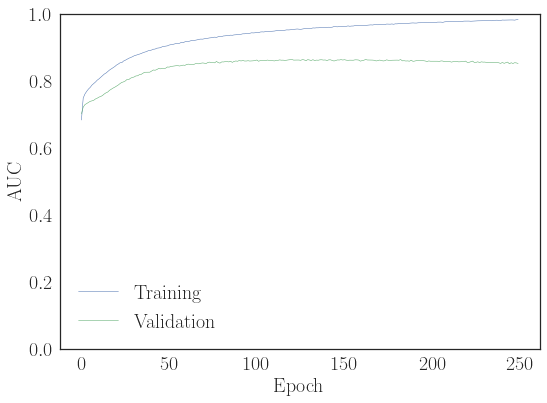

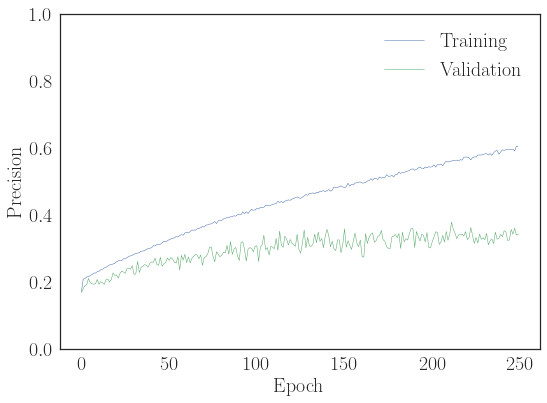

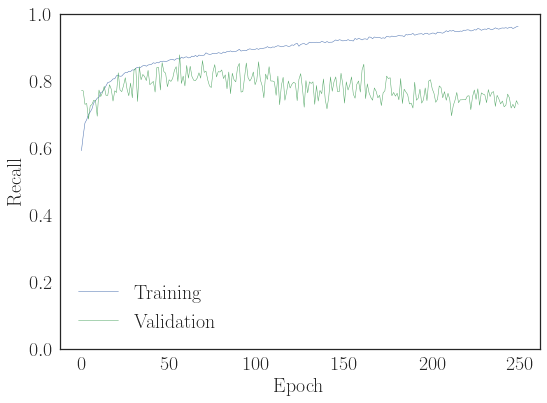

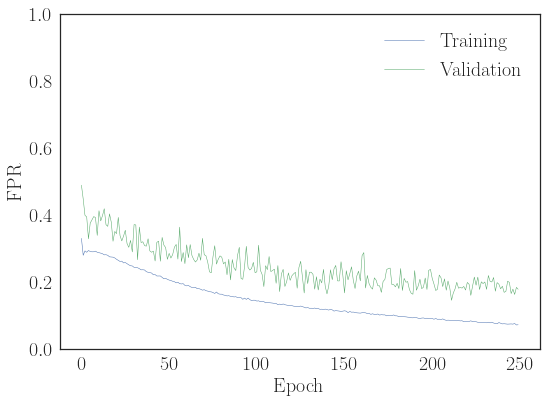

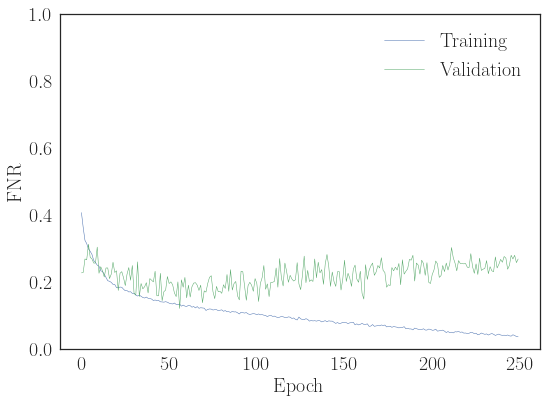

In [40]:
cap.show()

with open(os.path.join(model_dir, "log.txt"), "a") as f:
    f.write(cap.stdout)

In [31]:
sample_experience_dir = make_dir(os.path.join(Const.EXPERIENCE_DIR, "data-aug-sample"))
_, collector_sample = load_experience(case_name, agent_name, sample_experience_dir, env_dc=env_dc)

_, _, _, X_all_sample, Y_all_sample = create_dataset(
    case,
    collector_sample,
    input_mode=input_mode,
    label_mode=label_mode,
    n_window_history=n_window_history,
    n_window_targets=n_window_targets,
    downsampling_rate=downsampling_rate,
    n_window_forecasts=n_window_forecasts,
    use_actions=use_actions,
    feature_scaling=feature_scaling,
)


L2RPN_2019_ART (dc)


--------------------------------------------------------------------------------
                                        Loading Experience
--------------------------------------------------------------------------------
    - Loading chronics:                 ./experience/data-aug-sample/l2rpn_2019_art-dc/agent-mip-chronic-****
    - Number of loaded chronics:        10
    - Input structure:                  structured
    - Label structure:                  dn
    - Labels:                           655/60864	1.08 %



    - Dataset                          Chronic 0
        - Loss:                         0.3465
        - TP:                           26/33             78.79 %
        - FP:                           1101/6879         16.01 %
        - TN:                           5778/6879         83.99 %
        - FN:                           7/33              21.21 %
        - Accuracy:                     0.8397
        - Mcc:                          0.1172

    - Dataset                          Chronic 1
        - Loss:                         0.9649
        - TP:                           5/5              100.00 %
        - FP:                           73/195            37.44 %
        - TN:                           122/195           62.56 %
        - FN:                           0/5                0.00 %
        - Accuracy:                     0.6350
        - Mcc:                          0.2003

    - Dataset                          Chronic 2
        - Loss:                         

KeyError: 104

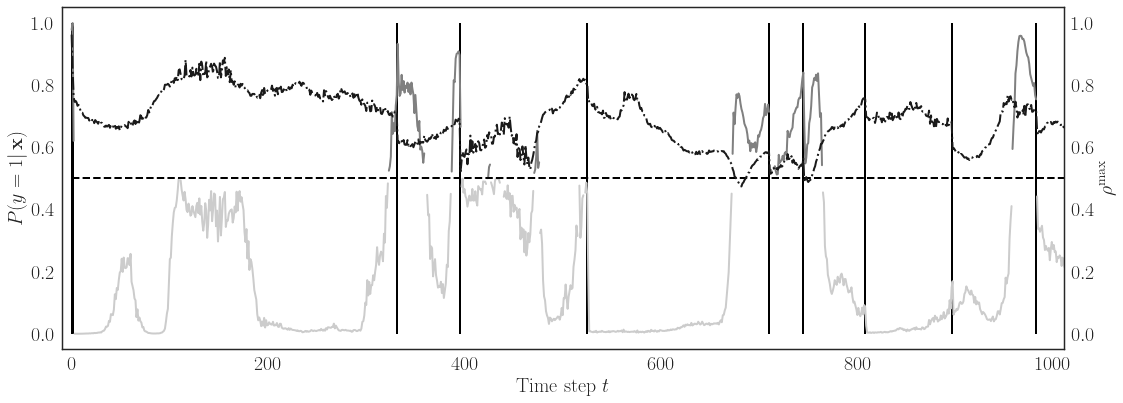

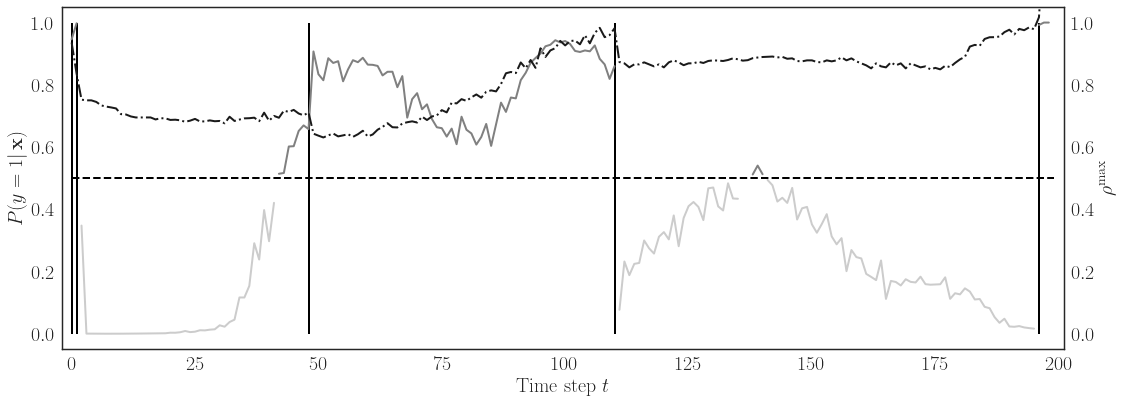

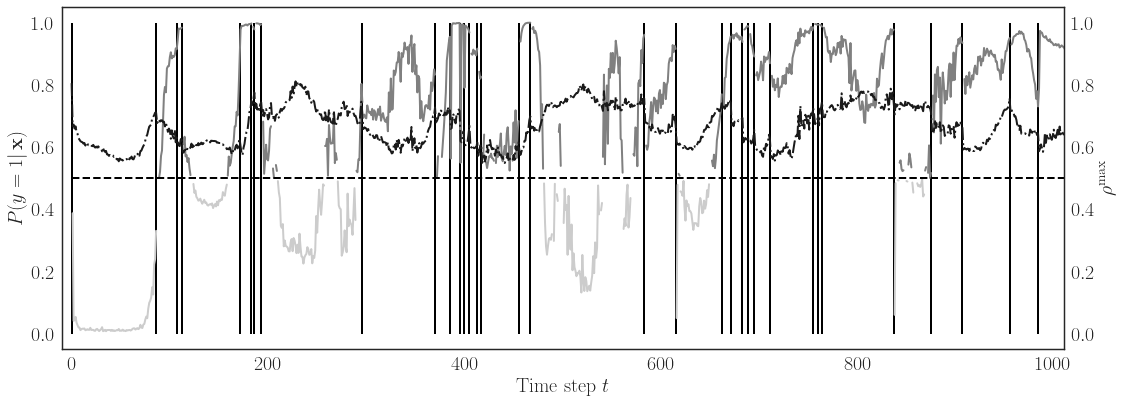

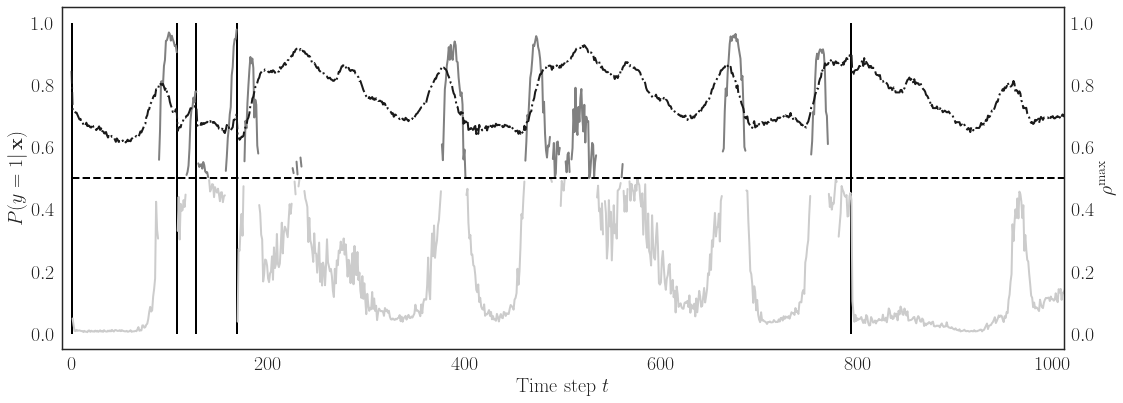

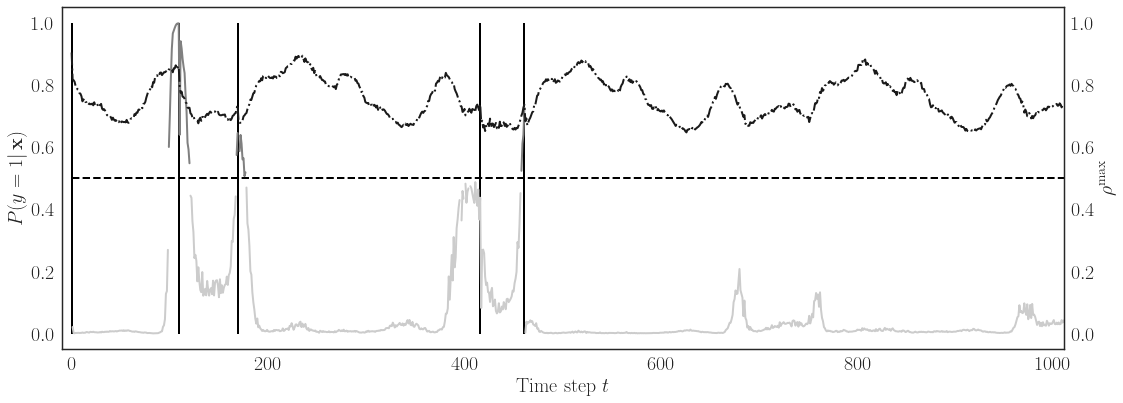

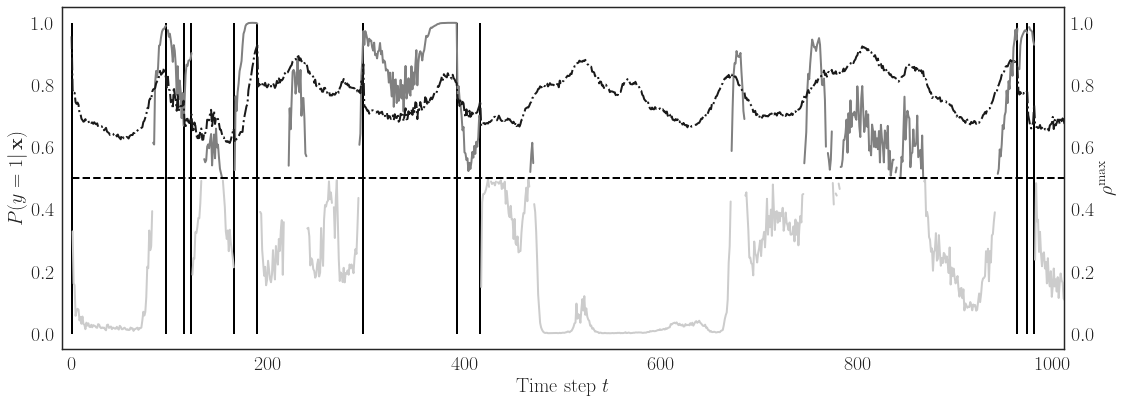

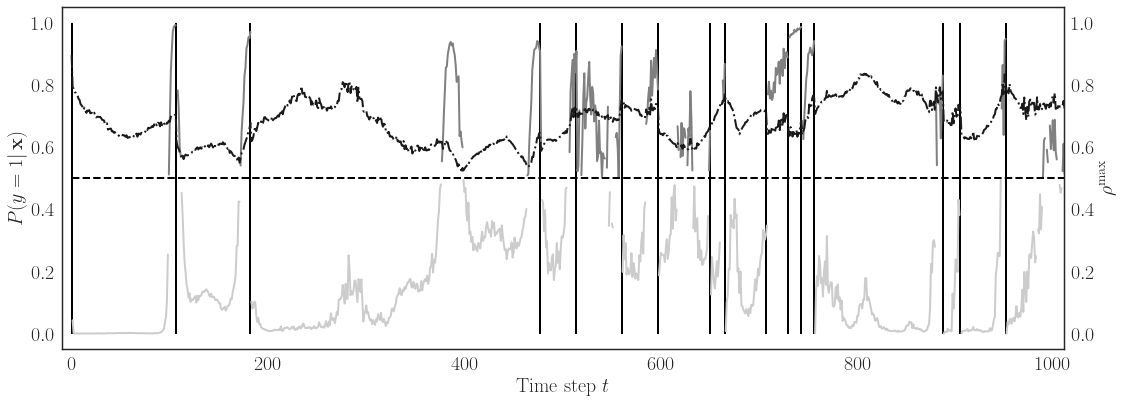

In [32]:
plt.style.use("seaborn-white")
plt.rcParams["font.family"] = "pcr"
plt.rcParams['axes.grid'] = False
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.title_fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20


def plot_preds(t, y, y_pred, rhos, threshold, chronic_idx=None):
    fig, ax = plt.subplots(figsize=(Const.FIG_SIZE[0] * 2, Const.FIG_SIZE[1]))

    indices_pos = np.equal(y, 1)
    ax.vlines(t[indices_pos], ymin=0.0, ymax=1.0, colors="0.0", linestyle="-", lw=2.0)
    
    indices_pos = np.greater(y_pred, threshold)
    pos = np.ma.masked_where(np.greater_equal(y_pred, threshold), y_pred)
    neg = np.ma.masked_where(np.less_equal(y_pred, threshold), y_pred)
    
    ax.plot(t, pos, color="0.8", lw=2.0)
    ax.plot(t, neg, color="0.5", lw=2.0)
    ax.plot(t, np.ones_like(t) * threshold, color="0", linestyle="--", lw=2.0)

    ax.set_xlabel(r"Time step $t$")
    ax.set_ylabel(r"$P(y = 1 | \, \mathbf{x})$")

    if ax.get_xlim()[-1] > 1000:
        ax.set_xlim(right=1010, left=-0.01 * 1000)
    else:
        ax.set_xlim(left=-0.01 * t.max(), right=1.01 * t.max())
                
    fig.tight_layout()
    if model_dir and not isinstance(chronic_idx, type(None)):
        fig.savefig(os.path.join(model_dir, "test-y-step-{:04}".format(chronic_idx)))
        
    if not isinstance(rhos, type(None)):
        ax2 = ax.twinx()
        ax2.set_ylabel(r"$\rho^\mathrm{max}$")
        ax2.plot(t, rhos, label=r"$y$", color="0.1", lw=2.0, linestyle="-.")
        ax2.set_ylim(*ax.get_ylim())
        
    fig.tight_layout()
    if model_dir and not isinstance(chronic_idx, type(None)):
        fig.savefig(os.path.join(model_dir, "test-y-step-{:04}-rhos".format(chronic_idx)))
        
start_idx = 0
for chronic_idx, chronic_len in zip(collector_sample.chronic_ids, collector_sample.chronic_lengths):
    X_chronic = X_all_sample[start_idx:(start_idx + chronic_len), :]
    Y_chronic = Y_all_sample[start_idx:(start_idx + chronic_len)]
    Y_chronic_pred = model.predict(X_chronic, batch_size=n_batch).flatten()
    
    results_chronic = model.evaluate(X_chronic, Y_chronic, batch_size=n_batch, verbose=0)
    describe_results(model.metrics_names, results_chronic, Y_chronic, name=f"Chronic {chronic_idx}")

    t = np.arange(chronic_len)
    rhos = [np.max(obs.rho) for obs in collector_sample.data[chronic_idx]["obses"][:-1]]
        
    plot_preds(t, Y_chronic, Y_chronic_pred, rhos, threshold, chronic_idx)
    
    start_idx = start_idx + chronic_len